In [1]:
import sys
sys.path.append("../../src")

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

## Load and preprocess data

In [4]:
import data

In [5]:
# set db path hackily
data._get_connection("../../data/participants.db")

raw_df = data.get_trials_df(data.load_raw_results(),
                            ("experiment_id", "materials_id", "item_id", "condition_id",
                             "practice_sentence"))

EXPERIMENT_ID = "02_acceptability_swarm"
response_df = raw_df[(raw_df.experiment_id == EXPERIMENT_ID) & (raw_df.trial_type == "html-slider-response-with-copout")] \
    .reset_index().set_index(["uniqueid", "trial_index"])

Missing datastring for uid A33LYSCQQU1YDJ:31JLPPHS2VIHTNHTYQX3Y0LM83NO3X. Status was 1.


In [6]:
# Expand condition labels, which are tuples
response_df = pd.concat([response_df, response_df.condition_id.apply(pd.Series).rename(columns=lambda x: f"condition_{x}")], axis=1) \
    .drop(columns="condition_id")

In [7]:
# Convert condition_id to independent features
response_df["agent_is_subject"] = response_df["condition_1"] == 1

In [8]:
# Norm slider values within-subject.
response_df["slider_zscore"] = \
    response_df.groupby("uniqueid").slider_value.apply(lambda xs: (xs - xs.mean()) / (xs.std(ddof=0)))

In [9]:
# dtype fixes
response_df["dateTime"] = pd.to_datetime(response_df.dateTime, unit="ms")

In [10]:
response_df.head()

condition  \
uniqueid                                     trial_index              
AUZNL6ARA1UEC:30LSNF239VJICJA7WV6TVTK8QRV2IY 3                    0   
                                             4                    0   
                                             5                    0   
                                             7                    0   
                                             8                    0   

                                                          counterbalance  \
uniqueid                                     trial_index                   
AUZNL6ARA1UEC:30LSNF239VJICJA7WV6TVTK8QRV2IY 3                         0   
                                             4                         0   
                                             5                         0   
                                             7                         0   
                                             8                         0   

                                                                            assignmentId  \
uniqueid                                     trial_index                                   
AUZNL6ARA1UEC:30LSNF239VJICJA7WV6TVTK8QRV2IY 3            30LSNF239VJICJA7WV6TVTK8QRV2IY   
                                             4            30LSNF239VJICJA7WV6TVTK8QRV2IY   
                                             5            30LSNF239VJICJA7WV6TVTK8QRV2IY   
                                             7            30LSNF239VJICJA7WV6TVTK8QRV2IY   
                                             8            30LSNF239VJICJA7WV6TVTK8QRV2IY   

                                                               workerId  \
uniqueid                                     trial_index                  
AUZNL6ARA1UEC:30LSNF239VJICJA7WV6TVTK8QRV2IY 3            AUZNL6ARA1UEC   
                                             4            AUZNL6ARA1UEC   
                                             5            AUZNL6ARA1UEC   
                                             7            AUZNL6ARA1UEC   
                                             8            AUZNL6ARA1UEC   

                                                                                   hitId  \
uniqueid                                     trial_index                                   
AUZNL6ARA1UEC:30LSNF239VJICJA7WV6TVTK8QRV2IY 3            3Y40HMYLL16LZ6ABOZBYG26P2L4UXT   
                                             4            3Y40HMYLL16LZ6ABOZBYG26P2L4UXT   
                                             5            3Y40HMYLL16LZ6ABOZBYG26P2L4UXT   
                                             7            3Y40HMYLL16LZ6ABOZBYG26P2L4UXT   
                                             8            3Y40HMYLL16LZ6ABOZBYG26P2L4UXT   

                                                                                trial_type  \
uniqueid                                     trial_index                                     
AUZNL6ARA1UEC:30LSNF239VJICJA7WV6TVTK8QRV2IY 3            html-slider-response-with-copout   
                                             4            html-slider-response-with-copout   
                                             5            html-slider-response-with-copout   
                                             7            html-slider-response-with-copout   
                                             8            html-slider-response-with-copout   

                                                               rt  \
uniqueid                                     trial_index            
AUZNL6ARA1UEC:30LSNF239VJICJA7WV6TVTK8QRV2IY 3            10886.3   
                                             4             9561.1   
                                             5             4337.5   
                                             7             6262.3   
                                             8             7395.1   

                                                         internal_no

In [11]:
response_df.to_csv("raw_responses.csv")

## Preliminaries

In [12]:
subjects = set(response_df.index.get_level_values("uniqueid"))

### Demo

In [13]:
qualitative_df = raw_df[(raw_df.experiment_id == EXPERIMENT_ID) & raw_df.trial_type.isin(("survey-text", "survey-multi-choice"))]

<AxesSubplot:xlabel='survey_answer', ylabel='Count'>

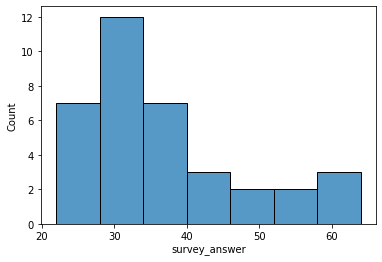

In [14]:
ages = qualitative_df[(qualitative_df.trial_type == "survey-text") & (qualitative_df.internal_node_id == "0.0-0.0")].survey_answer.astype(int)
sns.histplot(ages)

In [15]:
education = qualitative_df[(qualitative_df.trial_type == "survey-multi-choice") & (qualitative_df.survey_question_idx == 0)].survey_answer
education.value_counts()

Bachelor's degree    25
Master's degree       4
Some college          4
High school/GED       3
Name: survey_answer, dtype: int64

In [16]:
native = qualitative_df[(qualitative_df.trial_type == "survey-multi-choice") & (qualitative_df.survey_question_idx == 1)].survey_answer
native.value_counts()

Yes    36
Name: survey_answer, dtype: int64

### Comments

In [17]:
qualitative_df[(qualitative_df.trial_type == "survey-text") & (qualitative_df.internal_node_id != "0.0-0.0")].survey_answer

trial_index  uniqueid                                     
45           AUZNL6ARA1UEC:30LSNF239VJICJA7WV6TVTK8QRV2IY                                                      
             AT6ICEVY8RM8D:3WS1NTTKEZ0R6I53G0WU98E1D1J0FL                                                  None
             A1PKTH9O2E5FVD:3LEIZ60CDKNF7TKGH89U5BVCSA79ZU                                      VERY INTERSTING
             A38C4RKZTI9WNM:3HYA4D452S7Y2S8HVN08SW7GAZ3F2K                                                 none
             A2PIFMM4Q2I9ZS:3K772S5NP9ZAB4B3JXJ9XISINH6HEM                                                     
             A1VR1XQEQQXYUE:3X4JMASXCNX1T1TNBYAYQINGY3R0B3                                                     
             A3EHDY67QENKPT:3XXU1SWE8NJWAROV5KA2V73AGL60A8                                                     
             A71NZTTHS4AMB:3Z2R0DQ0JI26WE8L0CG2AEMGYYW2EX                                                      
             ARWN6TT8EWCFJ:3B1NLC6UG0K08Z5I85

### Total times

Text(0.5, 1.0, 'Total study time (minutes)')

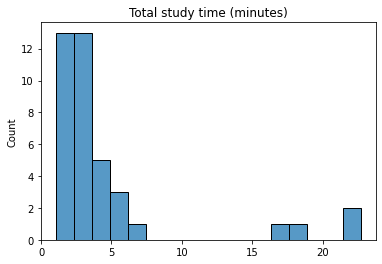

In [18]:
sns.histplot(pd.concat([response_df, qualitative_df]).groupby("uniqueid").apply(lambda rows: rows.rt.sum() / 1000 / 60))
plt.title("Total study time (minutes)")

In [19]:
pd.concat([response_df, qualitative_df]).groupby("uniqueid").rt.sum().apply(lambda xs: xs / 1000 / 60).agg(["mean", "std"])

mean    4.784119
std     5.444750
Name: rt, dtype: float64

### Response times

In [20]:
# sns.displot(data=response_df, x="rt", hue="uniqueid", kind="hist")

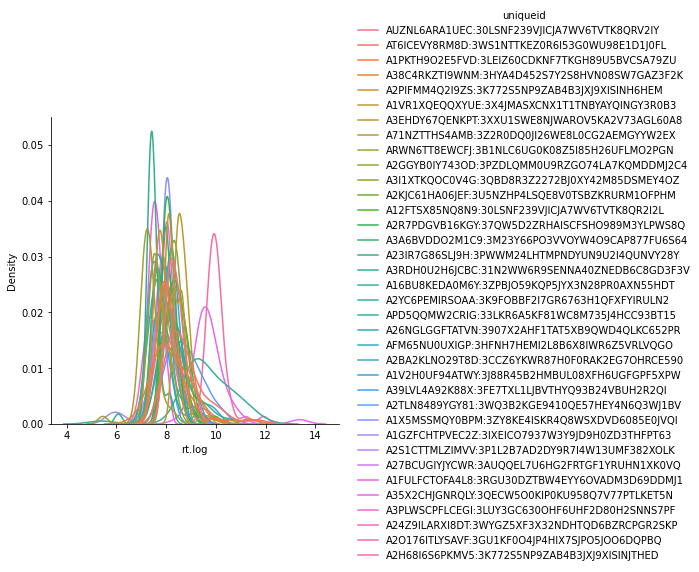

In [21]:
response_df["rt.log"] = np.log(response_df.rt)
sns.displot(data=response_df, x="rt.log", hue="uniqueid", kind="kde")

### How are people using the sliders?

- Stripplot points correspond to individual slider responses.
- Responses are grouped horizontally by subject.
- Transparent boxplots indicate filler response value for a particular subject. Red median lines / boxes indicate "good" fillers and blue indicate "bad."

<AxesSubplot:xlabel='uniqueid', ylabel='slider_value'>

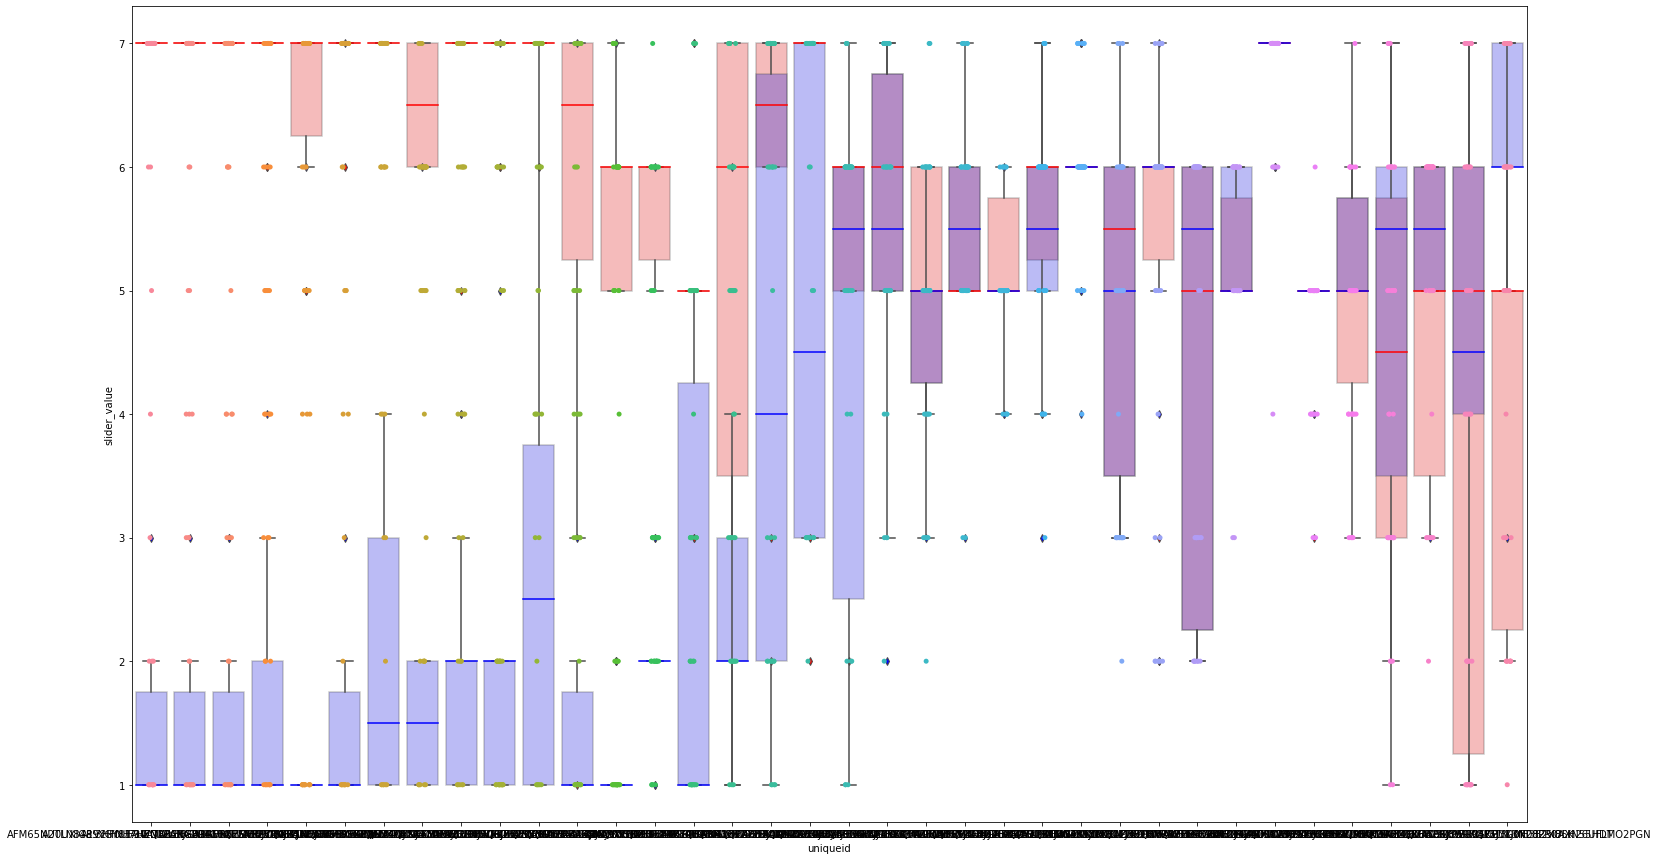

In [22]:
# Order S by descending difference between mean full-filler and empty-filler rating
filler_rows = response_df[response_df.condition_0 == "filler"]
filler_diffs = filler_rows.groupby("uniqueid").apply(
    lambda xs: xs[xs.condition_1 == "good"].slider_value.mean() - xs[xs.condition_1 == "bad"].slider_value.mean())
subject_order = filler_diffs.sort_values(ascending=False).index

plt.subplots(figsize=(25, 15))
g = sns.stripplot(data=response_df.reset_index(), x="uniqueid", y="slider_value", order=subject_order)

# plot filler responses
sns.boxplot(data=response_df[(response_df.condition_0 == "filler") & (response_df.condition_1 == "good")].reset_index(),
            x="uniqueid", y="slider_value", order=subject_order,
            color="red", medianprops=dict(color="red"), flierprops=dict(markerfacecolor="red"), boxprops=dict(alpha=0.3))
sns.boxplot(data=response_df[(response_df.condition_0 == "filler") & (response_df.condition_1 == "bad")].reset_index(),
            x="uniqueid", y="slider_value", order=subject_order, 
            color="blue", medianprops=dict(color="blue"), flierprops=dict(markerfacecolor="blue"), boxprops=dict(alpha=0.3))

## Attention checks

### Practice round

In [23]:
def compute_practice_success(subj_rows):
    """
    Compute fraction of practice sentences for which response equals
    ground truth.
    """
    practice_rows = subj_rows[~subj_rows.practice_sentence.isna()]
    practice_rows[["practice_rating", "practice_idx"]] = practice_rows.practice_sentence.str.split("-", 1, expand=True)
    success = practice_rows["practice_rating"].astype(int) == practice_rows["slider_value"]
    return success.mean()
    
practice_attention_failures = response_df.groupby("uniqueid").apply(compute_practice_success)
practice_attention_failures = practice_attention_failures[practice_attention_failures < 1]
practice_attention_failures

uniqueid
A1GZFCHTPVEC2Z:3IXEICO7937W3Y9JD9H0ZD3THFPT63    0.333333
A1PKTH9O2E5FVD:3LEIZ60CDKNF7TKGH89U5BVCSA79ZU    0.666667
A1VR1XQEQQXYUE:3X4JMASXCNX1T1TNBYAYQINGY3R0B3    0.666667
A23IR7G86SLJ9H:3PWWM24LHTMPNDYUN9U2I4QUNVY28Y    0.000000
A24Z9ILARXI8DT:3WYGZ5XF3X32NDHTQD6BZRCPGR2SKP    0.000000
A27BCUGIYJYCWR:3AUQQEL7U6HG2FRTGF1YRUHN1XK0VQ    0.000000
A2BA2KLNO29T8D:3CCZ6YKWR87H0F0RAK2EG7OHRCE590    0.000000
A2GGYB0IY743OD:3PZDLQMM0U9RZGO74LA7KQMDDMJ2C4    0.333333
A2H68I6S6PKMV5:3K772S5NP9ZAB4B3JXJ9XISINJTHED    0.333333
A2O176ITLYSAVF:3GU1KF0O4JP4HIX7SJPO5JOO6DQPBQ    0.000000
A2R7PDGVB16KGY:37QW5D2ZRHAISCFSHO989M3YLPWS8Q    0.333333
A2S1CTTMLZIMVV:3P1L2B7AD2DY9R7I4W13UMF382XOLK    0.000000
A2YC6PEMIRSOAA:3K9FOBBF2I7GR6763H1QFXFYIRULN2    0.666667
A35X2CHJGNRQLY:3QECW5O0KIP0KU958Q7V77PTLKET5N    0.000000
A38C4RKZTI9WNM:3HYA4D452S7Y2S8HVN08SW7GAZ3F2K    0.000000
A39LVL4A92K88X:3FE7TXL1LJBVTHYQ93B24VBUH2R2QI    0.666667
A3A6BVDDO2M1C9:3M23Y66PO3VVOYW4O9CAP877FU6S64    0.000000
A3I1X

### Fillers

<AxesSubplot:xlabel='t'>

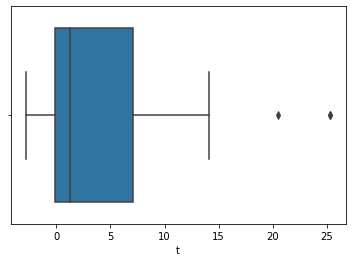

In [24]:
from scipy.stats import ttest_ind
def compute_filler_ttest(subj_rows):
    """
    sanity check: "good" items should be rated higher than "bad" filler items
    """
    filler_rows = subj_rows[subj_rows.condition_0 == "filler"]
    
    good_filler = filler_rows[filler_rows.condition_1 == "good"]
    bad_filler = filler_rows[filler_rows.condition_1 == "bad"]
    
    return pd.Series(ttest_ind(good_filler.slider_value, bad_filler.slider_value),
                     index=["t", "pval"])

filler_stats = response_df.groupby("uniqueid").apply(compute_filler_ttest)
sns.boxplot(data=filler_stats.reset_index(), x="t", hue="uniqueid")

In [25]:
filler_stats.sort_values("t")

,t,pval
uniqueid,,
ARWN6TT8EWCFJ:3B1NLC6UG0K08Z5I85H26UFLMO2PGN,-2.818469,1.137708e-02
A2S1CTTMLZIMVV:3P1L2B7AD2DY9R7I4W13UMF382XOLK,-0.974355,3.427938e-01
A24Z9ILARXI8DT:3WYGZ5XF3X32NDHTQD6BZRCPGR2SKP,-0.920358,3.695565e-01
A23IR7G86SLJ9H:3PWWM24LHTMPNDYUN9U2I4QUNVY28Y,-0.848528,4.072870e-01
A1PKTH9O2E5FVD:3LEIZ60CDKNF7TKGH89U5BVCSA79ZU,-0.600000,5.559852e-01
A16BU8KEDA0M6Y:3ZPBJO59KQP5JYX3N28PR0AXN55HDT,-0.485898,6.329020e-01
AT6ICEVY8RM8D:3WS1NTTKEZ0R6I53G0WU98E1D1J0FL,-0.474342,6.409598e-01
A2O176ITLYSAVF:3GU1KF0O4JP4HIX7SJPO5JOO6DQPBQ,-0.447214,6.600557e-01
A2BA2KLNO29T8D:3CCZ6YKWR87H0F0RAK2EG7OHRCE590,-0.144841,8.864456e-01


## Final data processing

In [26]:
exp_items = response_df[response_df.practice_sentence.isna()]

### Filter based on practice and attention checks

In [27]:
practice_drops = practice_attention_failures
drop_pct = np.round(len(practice_drops) / len(subjects) * 100 if len(practice_attention_failures) > 0 else 0, 1)
print(f"{len(practice_drops)} subjects ({drop_pct}%) disqualified and dropped due to failed practice.")
print("\t" + "\n\t".join(practice_drops.index))
exp_items = exp_items.drop(practice_drops.index, level="uniqueid")

attention_drops = filler_stats[(filler_stats.t < 0) | (filler_stats.pval > 1e-1) | filler_stats.t.isna()]
drop_pct = np.round(len(attention_drops) / len(filler_stats.index) * 100, 1)
print(f"{len(attention_drops)} subjects ({drop_pct}%, possibly overlapping with previous) disqualified and dropped due to failed attention checks.")
print("\t" + "\n\t".join(attention_drops.index))
exp_items = exp_items.drop(attention_drops.index, level="uniqueid")

23 subjects (63.9%) disqualified and dropped due to failed practice.
	A1GZFCHTPVEC2Z:3IXEICO7937W3Y9JD9H0ZD3THFPT63
	A1PKTH9O2E5FVD:3LEIZ60CDKNF7TKGH89U5BVCSA79ZU
	A1VR1XQEQQXYUE:3X4JMASXCNX1T1TNBYAYQINGY3R0B3
	A23IR7G86SLJ9H:3PWWM24LHTMPNDYUN9U2I4QUNVY28Y
	A24Z9ILARXI8DT:3WYGZ5XF3X32NDHTQD6BZRCPGR2SKP
	A27BCUGIYJYCWR:3AUQQEL7U6HG2FRTGF1YRUHN1XK0VQ
	A2BA2KLNO29T8D:3CCZ6YKWR87H0F0RAK2EG7OHRCE590
	A2GGYB0IY743OD:3PZDLQMM0U9RZGO74LA7KQMDDMJ2C4
	A2H68I6S6PKMV5:3K772S5NP9ZAB4B3JXJ9XISINJTHED
	A2O176ITLYSAVF:3GU1KF0O4JP4HIX7SJPO5JOO6DQPBQ
	A2R7PDGVB16KGY:37QW5D2ZRHAISCFSHO989M3YLPWS8Q
	A2S1CTTMLZIMVV:3P1L2B7AD2DY9R7I4W13UMF382XOLK
	A2YC6PEMIRSOAA:3K9FOBBF2I7GR6763H1QFXFYIRULN2
	A35X2CHJGNRQLY:3QECW5O0KIP0KU958Q7V77PTLKET5N
	A38C4RKZTI9WNM:3HYA4D452S7Y2S8HVN08SW7GAZ3F2K
	A39LVL4A92K88X:3FE7TXL1LJBVTHYQ93B24VBUH2R2QI
	A3A6BVDDO2M1C9:3M23Y66PO3VVOYW4O9CAP877FU6S64
	A3I1XTKQOC0V4G:3QBD8R3Z2272BJ0XY42M85DSMEY4OZ
	A3PLWSCPFLCEGI:3LUY3GC630OHF6UHF2D80H2SNNS7PF
	A71NZTTHS4AMB:3Z2R0DQ0JI26WE8L0CG2AEM

In [28]:
print(f"{len(set(exp_items.index.get_level_values('uniqueid')))} subjects remaining.")

10 subjects remaining.


### Merge in materials

In [29]:
import json
def load_materials(mat):
    with open(f"../../materials/{mat}.json") as f:
        materials = json.load(f)
    return pd.DataFrame.from_records(materials["items"]).rename(columns={"id": "item_id"}).set_index("item_id")

materials_ids = sorted(set(exp_items.materials_id))
materials_df = pd.concat([load_materials(mat) for mat in materials_ids], names=["materials_id"], keys=materials_ids, axis=0)

materials_df["AV"] = materials_df.A.str.cat(materials_df.V, " ")

# NB this doesn't handle fillers correctly

In [30]:
keep_cols = ["A", "V", "L", "AV", "A concrete?", "A countable?"]
merged_df = pd.merge(exp_items, materials_df[keep_cols], left_on=["materials_id", "item_id"], right_index=True)

### Export

In [31]:
merged_df.to_csv("merged_df.csv")

## Analysis

<AxesSubplot:xlabel='uniqueid', ylabel='slider_value'>

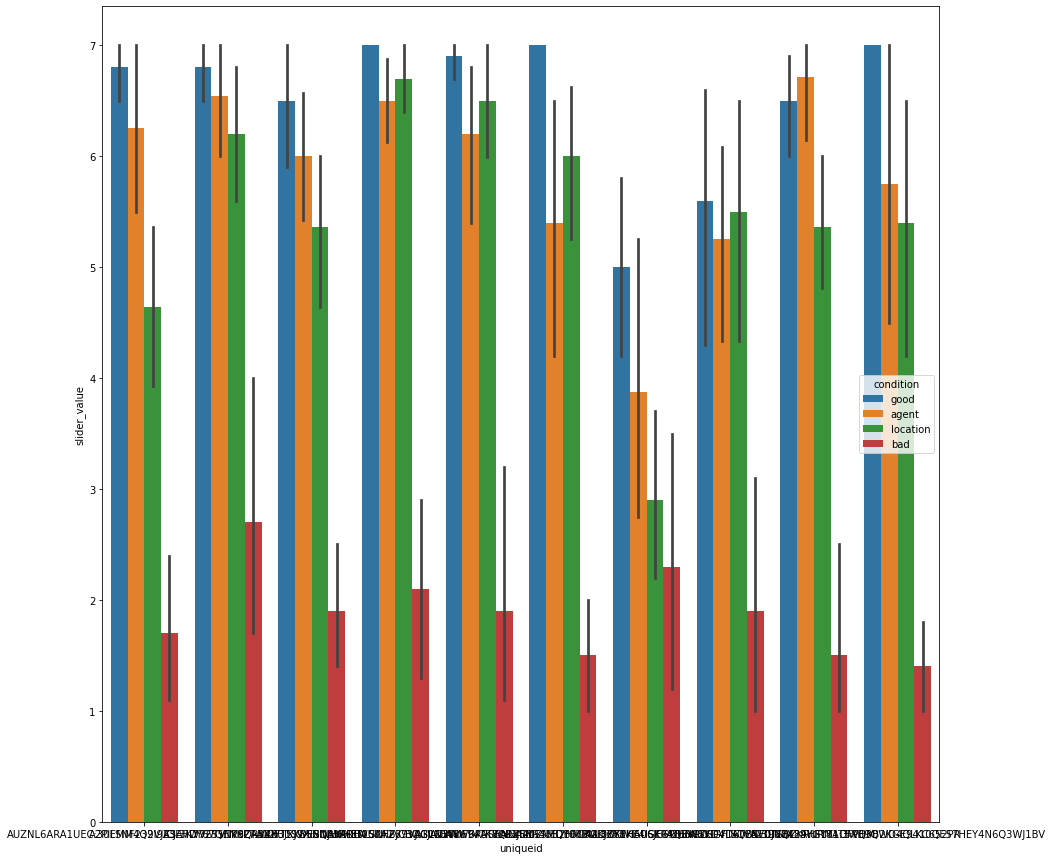

In [32]:
def condition_shortname(row):
    if row.condition_0 == "filler":
        return row.condition_1
    else:
        return "agent" if row.condition_1 == 1 else "location"
    
acceptability_df = merged_df.copy()
acceptability_df["condition"] = acceptability_df.apply(condition_shortname, axis=1)
acceptability_df = acceptability_df.reset_index().set_index(["uniqueid", "condition", "item_id"])

plt.subplots(figsize=(15, 15))
hue_order = ["good", "agent", "location", "bad"]
sns.barplot(data=acceptability_df.reset_index(),
            x="uniqueid", y="slider_value", 
            hue="condition", hue_order=hue_order)

In [33]:
def test_within_subject(rows):
    baseline = rows[(rows.condition_0 == "filler") & (rows.condition_1 == "bad")].slider_value
    critical_rows = rows[~(rows.condition_0 == "filler")].set_index("agent_is_subject").slider_value
    
    location_t, location_pval = ttest_ind(critical_rows.loc[False], baseline)
    agent_t, agent_pval = ttest_ind(critical_rows.loc[True], baseline)
    return pd.Series({"location_t": location_t, "location_pval": location_pval,
                      "agent_t": agent_t, "agent_pval": agent_pval})
merged_df.groupby("uniqueid").apply(test_within_subject)

,location_t,location_pval,agent_t,agent_pval
uniqueid,,,,
A12FTSX85NQ8N9:30LSNF239VJICJA7WV6TVTK8QR2I2L,10.584117,3.702182e-09,9.025641,1.121190e-07
A1V2H0UF94ATWY:3J88R45B2HMBUL08XFH6UGFGPF5XPW,9.965458,2.882279e-08,5.785278,1.754640e-05
A1X5MSSMQY0BPM:3ZY8KE4ISKR4Q8WSXDVD6085E0JVQI,0.830278,4.172584e-01,1.729479,1.029645e-01
A26NGLGGFTATVN:3907X2AHF1TAT5XB9QWD4QLKC652PR,6.705079,2.075740e-06,8.047773,8.001501e-07
A2KJC61HA06JEF:3U5NZHP4LSQE8V0TSBZKRURM1OFPHM,3.914630,1.556303e-03,4.403038,2.742671e-04
A2PIFMM4Q2I9ZS:3K772S5NP9ZAB4B3JXJ9XISINH6HEM,3.792852,2.237513e-03,6.211236,3.673206e-06
A2TLN8489YGY81:3WQ3B2KGE9410QE57HEY4N6Q3WJ1BV,6.092077,9.338213e-06,6.944738,3.301398e-06
A3EHDY67QENKPT:3XXU1SWE8NJWAROV5KA2V73AGL60A8,7.136191,8.758112e-07,8.971379,2.043002e-07
A3RDH0U2H6JCBC:31N2WW6R9SENNA40ZNEDB6C8GD3F3V,6.219447,1.227400e-05,6.115186,8.909314e-06


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17]),
 [Text(0, 0, 'excitement puls'),
  Text(1, 0, 'fear prickl'),
  Text(2, 0, 'terror cours'),
  Text(3, 0, 'cockroaches creep'),
  Text(4, 0, 'sewage runn'),
  Text(5, 0, 'people bustl'),
  Text(6, 0, 'excitement crackl'),
  Text(7, 0, 'debris flow'),
  Text(8, 0, 'worms wriggl'),
  Text(9, 0, 'conversation buzz'),
  Text(10, 0, 'bees swarm'),
  Text(11, 0, 'ants crawl'),
  Text(12, 0, 'energy humm'),
  Text(13, 0, 'tadpoles swimm'),
  Text(14, 0, 'frogs hopp'),
  Text(15, 0, 'trumpets ring'),
  Text(16, 0, 'bubbles foam'),
  Text(17, 0, 'lights glow')])

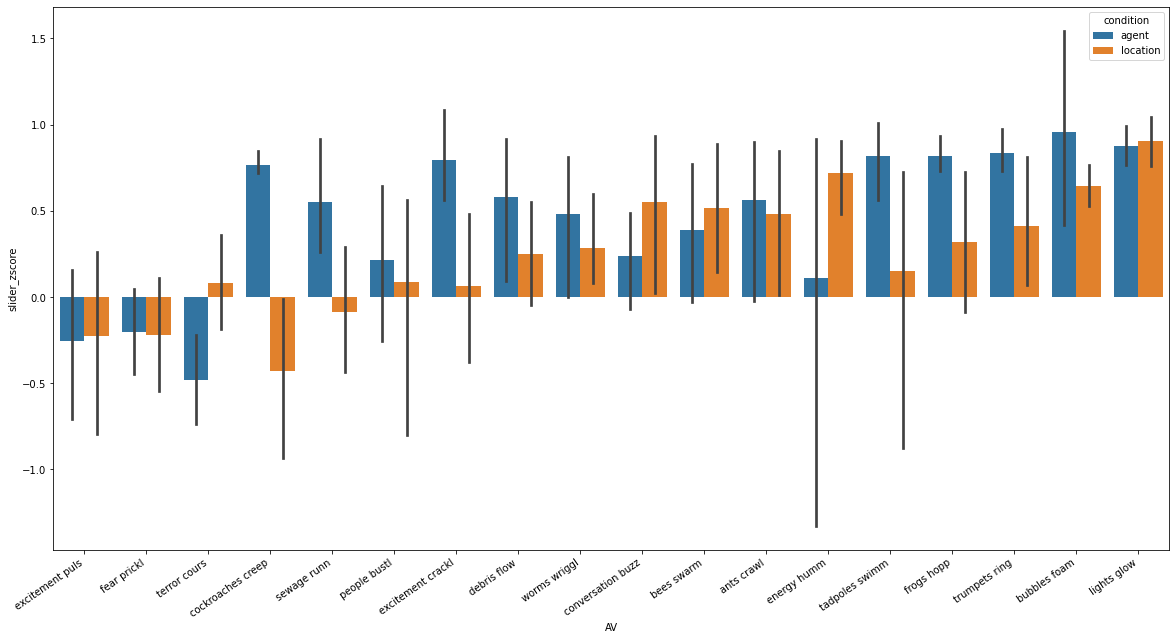

In [34]:
exp_conditions = ["agent", "location"]
item_graph_data = acceptability_df.loc[(slice(None), exp_conditions), :].reset_index()
order = item_graph_data.groupby(["item_id", "AV"]).slider_zscore.mean().sort_values().index.get_level_values(1)

plt.subplots(figsize=(20, 10))
sns.barplot(data=item_graph_data, 
            x="AV", order=order,
            y="slider_zscore",
            hue="condition", hue_order=exp_conditions)
plt.xticks(rotation=35, ha="right")

### Item exposure

In [39]:
merged_df[merged_df.condition_0 != "filler"] \
    .groupby(["item_id", "AV", "agent_is_subject"]).size().sort_values()

item_id  AV                 agent_is_subject
17.0     debris flow        True                3
39.0     sewage runn        True                3
25.0     energy humm        True                3
4.0      people bustl       False               3
7.0      excitement crackl  True                3
56.0     tadpoles swimm     False               4
31.0     excitement puls    False               4
30.0     fear prickl        False               4
24.0     frogs hopp         False               4
22.0     lights glow        False               4
19.0     bubbles foam       True                4
64.0     worms wriggl       False               4
8.0      cockroaches creep  True                4
0.0      bees swarm         False               4
6.0      terror cours       True                4
5.0      conversation buzz  True                4
2.0      ants crawl         False               5
                            True                5
3.0      trumpets ring      False               5
     

### Concreteness

In [35]:
acceptability_df["A concrete?"]

uniqueid                                       condition  item_id
AUZNL6ARA1UEC:30LSNF239VJICJA7WV6TVTK8QRV2IY   good       29.0           
A2PIFMM4Q2I9ZS:3K772S5NP9ZAB4B3JXJ9XISINH6HEM  good       29.0           
A3EHDY67QENKPT:3XXU1SWE8NJWAROV5KA2V73AGL60A8  good       29.0           
A12FTSX85NQ8N9:30LSNF239VJICJA7WV6TVTK8QR2I2L  good       29.0           
A3RDH0U2H6JCBC:31N2WW6R9SENNA40ZNEDB6C8GD3F3V  good       29.0           
                                                                     ... 
                                                          18.0       True
A26NGLGGFTATVN:3907X2AHF1TAT5XB9QWD4QLKC652PR  good       18.0       True
A1V2H0UF94ATWY:3J88R45B2HMBUL08XFH6UGFGPF5XPW  good       18.0       True
A2TLN8489YGY81:3WQ3B2KGE9410QE57HEY4N6Q3WJ1BV  good       18.0       True
A1X5MSSMQY0BPM:3ZY8KE4ISKR4Q8WSXDVD6085E0JVQI  good       18.0       True
Name: A concrete?, Length: 380, dtype: object

<AxesSubplot:xlabel='condition', ylabel='slider_zscore'>

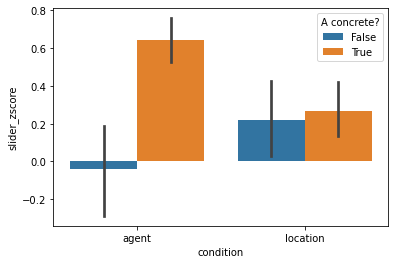

In [36]:
sns.barplot(data=acceptability_df.loc[(slice(None), ["agent", "location"]), :].reset_index(),
            x="condition", y="slider_zscore", hue="A concrete?")